In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
warnings.filterwarnings('ignore')

In [ ]:
# Load dataset
directory = r"C:\Users\Bhuvana\Downloads\indian_liver_patient.csv"
data = pd.read_csv(directory)

In [ ]:
# Map target labels correctly
data['Dataset'] = data['Dataset'].map({2: 0, 1: 1})

In [ ]:
data['Gender'] = data['Gender'].apply(lambda x: 1 if x == 'Male' else 0)

In [ ]:
print(data['Gender'].value_counts())

Gender
1    441
0    142
Name: count, dtype: int64


In [ ]:
data = data.drop_duplicates()
data.shape

(570, 11)

In [ ]:
#data=data.dropna(how='any')
data['Albumin_and_Globulin_Ratio'].fillna(data['Albumin_and_Globulin_Ratio'].mean(), inplace=True)

data.shape

(570, 11)

In [ ]:
data = data[data.Aspartate_Aminotransferase<=2500]
data.shape

(568, 11)

In [ ]:
data.head()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
0,65,0,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,1,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,1,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,1,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,1,3.9,2.0,195,27,59,7.3,2.4,0.40,1


In [ ]:
data.shape

(568, 11)

In [ ]:
# Split features and target variable
X = data.drop('Dataset', axis=1)
y = data['Dataset']

In [ ]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:

# Perform feature scaling **after** encoding categorical variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform training data
X_test_scaled = scaler.transform(X_test)  # Transform test data using the same scaler
# Convert scaled arrays back to DataFrames (optional)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)
# Verify shapes
print("Shape of X_train_scaled:", X_train_scaled.shape)
print("Shape of X_test_scaled:", X_test_scaled.shape)

Shape of X_train_scaled: (454, 10)
Shape of X_test_scaled: (114, 10)


In [ ]:
print("Mean of scaled training data (should be ~0):")
print(np.round(X_train_scaled.mean(), 2))

print("\nStandard deviation of scaled training data (should be ~1):")
print(np.round(X_train_scaled.std(), 2))

print("Mean of scaled test data (should not necessarily be ~0):")
print(np.round(X_test_scaled.mean(), 2))

print("\nStandard deviation of scaled test data (should not necessarily be ~1):")
print(np.round(X_test_scaled.std(), 2))

Mean of scaled training data (should be ~0):
Age                           0.0
Gender                       -0.0
Total_Bilirubin               0.0
Direct_Bilirubin              0.0
Alkaline_Phosphotase          0.0
Alamine_Aminotransferase      0.0
Aspartate_Aminotransferase    0.0
Total_Protiens               -0.0
Albumin                       0.0
Albumin_and_Globulin_Ratio    0.0
dtype: float64

Standard deviation of scaled training data (should be ~1):
Age                           1.0
Gender                        1.0
Total_Bilirubin               1.0
Direct_Bilirubin              1.0
Alkaline_Phosphotase          1.0
Alamine_Aminotransferase      1.0
Aspartate_Aminotransferase    1.0
Total_Protiens                1.0
Albumin                       1.0
Albumin_and_Globulin_Ratio    1.0
dtype: float64
Mean of scaled test data (should not necessarily be ~0):
Age                           0.10
Gender                        0.08
Total_Bilirubin               0.30
Direct_Bilirubin       

In [ ]:
print("Class distribution in y_train:")
print(y_train.value_counts())

Class distribution in y_train:
Dataset
1    323
0    131
Name: count, dtype: int64


In [ ]:
# Apply SMOTE to training set
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

In [ ]:
# Verify the class distribution after SMOTE
print("Class distribution after SMOTE:")
print(pd.Series(y_train_smote).value_counts())


Class distribution after SMOTE:
Dataset
1    323
0    323
Name: count, dtype: int64


In [ ]:
# Implement Elastic Net for feature selection
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X_train_smote, y_train_smote)

# Select features with non-zero coefficients
feature_importance = pd.Series(elastic_net.coef_, index=X_train_smote.columns)
selected_features = feature_importance[feature_importance != 0].index.tolist()

# Use selected features
X_train_selected = X_train_smote[selected_features]
X_test_selected = X_test_scaled[selected_features]

# Print results
print("Selected features by Elastic Net:", selected_features)
print("Shape of X_train_selected after feature selection:", X_train_selected.shape)
print("Shape of X_test_selected after feature selection:", X_test_selected.shape)

Selected features by Elastic Net: ['Age', 'Total_Bilirubin', 'Direct_Bilirubin', 'Alkaline_Phosphotase', 'Aspartate_Aminotransferase']
Shape of X_train_selected after feature selection: (646, 5)
Shape of X_test_selected after feature selection: (114, 5)


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.85      0.64        33
           1       0.92      0.67      0.77        81

    accuracy                           0.72       114
   macro avg       0.71      0.76      0.70       114
weighted avg       0.80      0.72      0.73       114

ROC-AUC Score: 0.8189300411522633


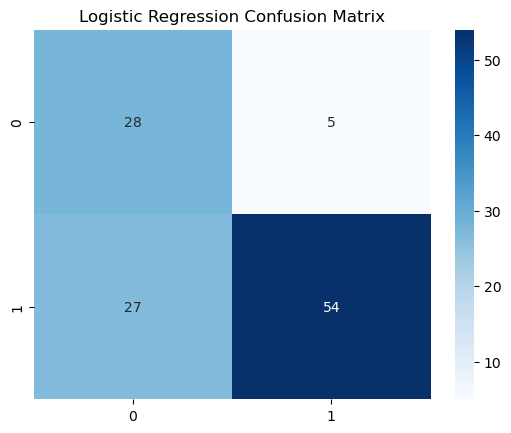

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Train the model
log_reg = LogisticRegression(class_weight='balanced',random_state=42)
log_reg.fit(X_train_selected, y_train_smote)

# Evaluate the model
y_pred_log_reg = log_reg.predict(X_test_selected)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log_reg))
print("ROC-AUC Score:", roc_auc_score(y_test, log_reg.predict_proba(X_test_selected)[:, 1]))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_log_reg), annot=True, fmt='d', cmap='Blues')
plt.title("Logistic Regression Confusion Matrix")
plt.show()

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.61      0.54        33
           1       0.82      0.74      0.78        81

    accuracy                           0.70       114
   macro avg       0.65      0.67      0.66       114
weighted avg       0.73      0.70      0.71       114

ROC-AUC Score: 0.7976056864945753


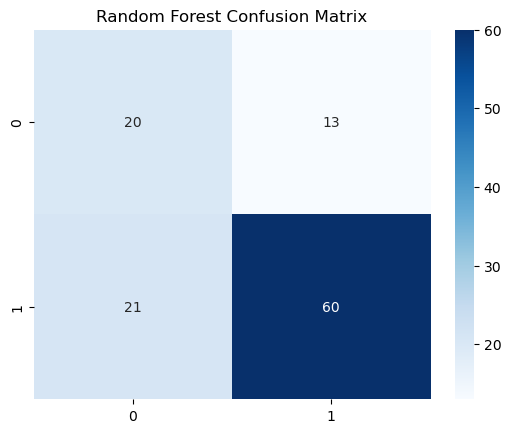

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Train the model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_selected, y_train_smote)

# Evaluate the model
y_pred_rf = rf.predict(X_test_selected)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC Score:", roc_auc_score(y_test, rf.predict_proba(X_test_selected)[:, 1]))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.show()

SVC Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.88      0.63        33
           1       0.93      0.63      0.75        81

    accuracy                           0.70       114
   macro avg       0.71      0.75      0.69       114
weighted avg       0.80      0.70      0.72       114

ROC-AUC Score: 0.7919940142162365


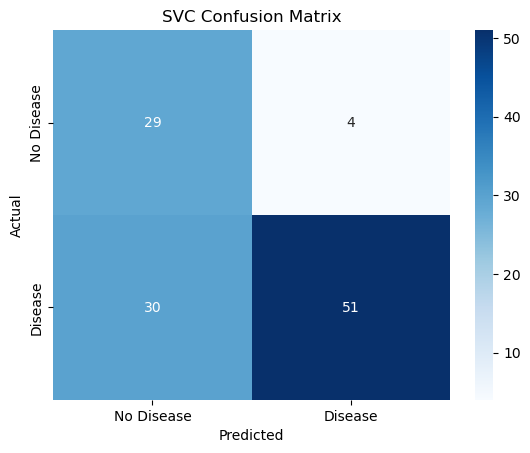

In [ ]:
# Import necessary libraries
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize the SVC model
svc = SVC(random_state=42, probability=True)  # Enable probability for ROC-AUC

# Train the model
svc.fit(X_train_selected, y_train_smote)

# Evaluate the model
y_pred_svc = svc.predict(X_test_selected)
y_pred_proba_svc = svc.predict_proba(X_test_selected)[:, 1]  # Probabilities for ROC-AUC

# Classification Report
print("SVC Classification Report:")
print(classification_report(y_test, y_pred_svc))

# ROC-AUC Score
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba_svc))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_svc)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'])
plt.title("SVC Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

k-NN Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.76      0.61        33
           1       0.88      0.70      0.78        81

    accuracy                           0.72       114
   macro avg       0.69      0.73      0.70       114
weighted avg       0.77      0.72      0.73       114

ROC-AUC Score: 0.7929292929292929


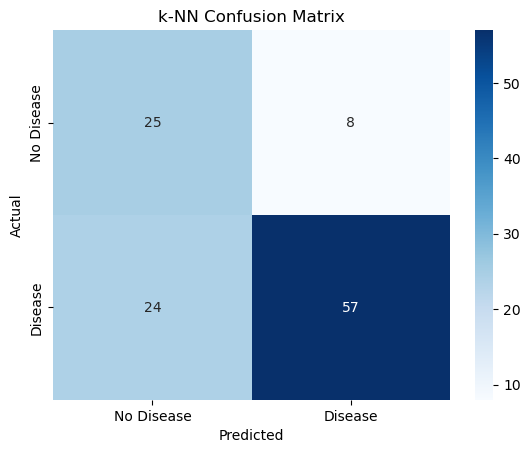

In [ ]:
# Import necessary libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize the k-NN model
knn = KNeighborsClassifier()

# Train the model
knn.fit(X_train_selected, y_train_smote)

# Evaluate the model
y_pred_knn = knn.predict(X_test_selected)
y_pred_proba_knn = knn.predict_proba(X_test_selected)[:, 1]  # Probabilities for ROC-AUC

# Classification Report
print("k-NN Classification Report:")
print(classification_report(y_test, y_pred_knn))

# ROC-AUC Score
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba_knn))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'])
plt.title("k-NN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

LDA Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.85      0.59        33
           1       0.90      0.58      0.71        81

    accuracy                           0.66       114
   macro avg       0.68      0.71      0.65       114
weighted avg       0.77      0.66      0.67       114

ROC-AUC Score: 0.7860082304526749


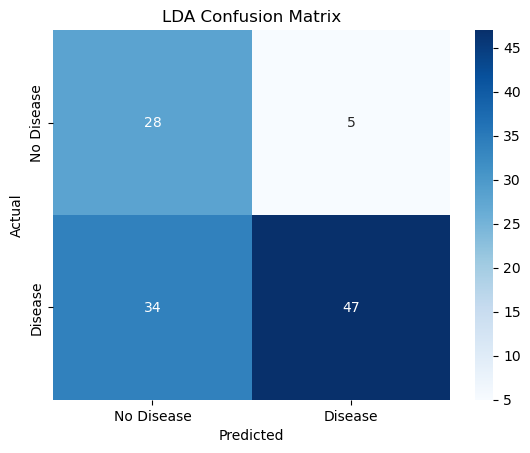

In [ ]:
# Import necessary libraries
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize the LDA model
lda = LinearDiscriminantAnalysis()

# Train the model
lda.fit(X_train_selected, y_train_smote)

# Evaluate the model
y_pred_lda = lda.predict(X_test_selected)
y_pred_proba_lda = lda.predict_proba(X_test_selected)[:, 1]  # Probabilities for ROC-AUC

# Classification Report
print("LDA Classification Report:")
print(classification_report(y_test, y_pred_lda))

# ROC-AUC Score
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba_lda))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_lda)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'])
plt.title("LDA Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.85      0.64        33
           1       0.92      0.68      0.78        81

    accuracy                           0.73       114
   macro avg       0.72      0.76      0.71       114
weighted avg       0.80      0.73      0.74       114

ROC-AUC Score: 0.8163112607557051


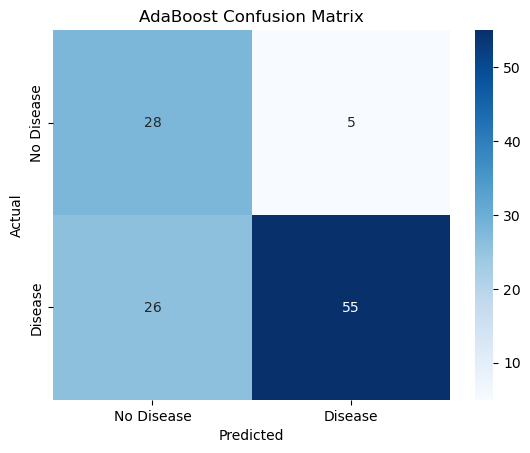

In [ ]:
# Import necessary libraries
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize the base estimator (weak classifier)
base_estimator = SVC(probability=True, kernel='linear', random_state=42)

# Initialize the AdaBoost model
adaboost = AdaBoostClassifier(
    estimator=base_estimator,
    n_estimators=30,  # Number of weak learners
    learning_rate=0.5,  # Contribution of each weak learner
    random_state=42
)

# Train the model
adaboost.fit(X_train_selected, y_train_smote)

# Evaluate the model
y_pred_adaboost = adaboost.predict(X_test_selected)
y_pred_proba_adaboost = adaboost.predict_proba(X_test_selected)[:, 1]  # Probabilities for ROC-AUC

# Classification Report
print("AdaBoost Classification Report:")
print(classification_report(y_test, y_pred_adaboost))

# ROC-AUC Score
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba_adaboost))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_adaboost)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'])
plt.title("AdaBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Bagging Classifier (Decision Tree) Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.88      0.64        33
           1       0.93      0.65      0.77        81

    accuracy                           0.72       114
   macro avg       0.72      0.77      0.71       114
weighted avg       0.81      0.72      0.73       114

ROC-AUC Score: 0.8166853722409277


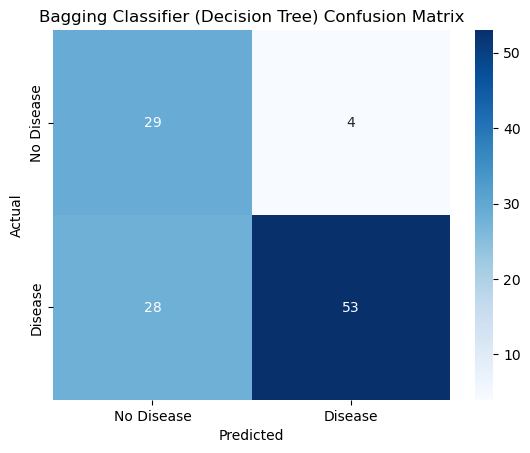

In [ ]:
#Bagging with Decision Trees
# Import necessary libraries
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize the base estimator (Decision Tree)


# Initialize the Bagging Classifier
bagging_clf = BaggingClassifier(
  estimator= LogisticRegression( random_state=42,max_iter=500),
    n_estimators=10,
    max_samples=1.0,
    max_features=1.0,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

# Train the Bagging Classifier
bagging_clf.fit(X_train_selected, y_train_smote)

# Evaluate the model
y_pred_bagging = bagging_clf.predict(X_test_selected)
y_pred_proba_bagging = bagging_clf.predict_proba(X_test_selected)[:, 1]  # Probabilities for ROC-AUC

# Classification Report
print("Bagging Classifier (Decision Tree) Classification Report:")
print(classification_report(y_test, y_pred_bagging))

# ROC-AUC Score
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba_bagging))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_bagging)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'])
plt.title("Bagging Classifier (Decision Tree) Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
#('dt', DecisionTreeClassifier(random_state=42)),
   #('rf', RandomForestClassifier(random_state=42)),
#('mlp', MLPClassifier(random_state=42, max_iter=500)),
   #('svc', SVC(probability=True, random_state=42)),
 #('nb', GaussianNB()),
# ('bagging', BaggingClassifier(base_estimator=GradientBoostingClassifier(), random_state=42)),
    #('gb', GradientBoostingClassifier(random_state=42))

In [ ]:
# Import libraries
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# Base models
base_models = [

   ('lr', LogisticRegression(random_state=42)),
   ('xgb', XGBClassifier(random_state=42)),
  ('knn', KNeighborsClassifier()),
   ('lgbm', LGBMClassifier(random_state=42)),
   ('catboost', CatBoostClassifier(verbose=0, random_state=42)),
    ]

# Meta-classifier
meta_classifier = GradientBoostingClassifier(random_state=42)

# Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_classifier,
    stack_method='auto',
    cv=5,
    n_jobs=-1
)

# Train and evaluate
stacking_clf.fit(X_train_selected, y_train_smote)
y_pred = stacking_clf.predict(X_test_selected)
y_pred_proba = stacking_clf.predict_proba(X_test_selected)[:, 1]

# Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.79      0.69        33
           1       0.90      0.80      0.85        81

    accuracy                           0.80       114
   macro avg       0.76      0.80      0.77       114
weighted avg       0.82      0.80      0.80       114

ROC-AUC Score: 0.842499064721287
